In [2]:
%reset -f
import tweepy
import pandas as pd
import json
import warnings
import time
import os
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
# Load Twitter credentials
api_keys = json.load(open('twitter-api-keys.local.json'))
bearer_token = api_keys["bearer_token"]
client = tweepy.Client(
    bearer_token=api_keys['bearer_token'], wait_on_rate_limit=True)

auth = tweepy.OAuthHandler(
    consumer_key=api_keys['api_key'],
    consumer_secret=api_keys['api_key_secret'],
    access_token=api_keys['access_token'],
    access_token_secret=api_keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
filename = 'twitter.csv'
if filename in os.listdir('.'):
    df = pd.read_csv(filename)
else:
    df = pd.DataFrame(columns=[
        'id',
        'screen_name',
        'followers_count',
        'following_count',
        'verified',
        'followers',
        'friends',
        'mutuals'])

me = 'fcx_xm'
exclude = 'vodafone_es'

In [5]:
# Get my info and fill in the dataframe
# check if my info is already in the dataframe
if me not in df['screen_name'].values:
    me_info = api.get_user(screen_name=me)
    df = df.append({
        'id': me_info.id,
        'screen_name': me_info.screen_name,
        'followers_count': me_info.followers_count,
        'following_count': me_info.friends_count,
        'verified': me_info.verified,
        'followers': '',
        'friends': ''}, ignore_index=True)


In [6]:
def get_followers(screen_name):
    start = time.time()
    print('Getting followers')
    global df
    if not (df.loc[df['screen_name'] == screen_name, 'followers'].values[0] != '' and pd.isna(df.loc[df['screen_name'] == screen_name, 'followers'].values[0])):
        print('- Already have followers for ' + screen_name)
        return

    ids = []
    for fid in tweepy.Cursor(api.get_follower_ids, screen_name=screen_name, count=5000).items():
        ids.append(fid)

    info = []
    for i in range(0, len(ids), 100):
        try:
            chunk = ids[i:i+100]
            print('- Getting followers info for chunk ' + str(i) + ' to ' +
                  str(i+100) + ' of ' + str(len(ids)) + ' for ' + screen_name)
            info.extend(api.lookup_users(user_id=chunk))
        except:
            import traceback
            traceback.print_exc()
            print('Something went wrong, skipping...')

    followers_list = {}
    for i in info:
        followers_list[i.id] = i.screen_name
        if i.id not in df['id'].values:
            df = df.append({
                'id': i.id,
                'screen_name': i.screen_name,
                'followers_count': i.followers_count,
                'following_count': i.friends_count,
                'verified': i.verified,
                'followers': '',
                'friends': ''},
                ignore_index=True)

    df.loc[df['screen_name'] == screen_name,
           'followers'] = json.dumps(followers_list)
    df.to_csv(filename, index=False)
    end = time.time()
    print('Done getting followers in {} seconds'.format(end - start))


In [7]:
df.loc[df['screen_name'] == me, 'friends'].values[0] != '' or pd.isna(df.loc[df['screen_name'] == me, 'friends'].values[0])

True

In [8]:
def get_friends(screen_name):
    start = time.time()
    print('Getting friends')
    global df

    # check if df has any row

    if not (df.loc[df['screen_name'] == screen_name, 'friends'].values[0] != '' and pd.isna(df.loc[df['screen_name'] == screen_name, 'friends'].values[0])):
        print('- Already have friends for ' + screen_name)
        return 

    ids = []
    for fid in tweepy.Cursor(api.get_friend_ids, screen_name=screen_name, count=5000).items():
        ids.append(fid)
    
    info = []
    for i in range(0, len(ids), 100):
        try:
            chunk = ids[i:i+100]
            # print chunk and len of ids
            print('- Getting friends info for chunk ' + str(i) + ' to ' + str(i+100) + ' of ' + str(len(ids)) + ' for ' + screen_name)
            info.extend(api.lookup_users(user_id=chunk))
        except:
            import traceback
            traceback.print_exc()
            print('Something went wrong, skipping...')

    followers_list = {}
    for i in info:
        followers_list[i.id] = i.screen_name
        if i.id not in df['id'].values:
            df = df.append({
                'id': i.id,
                'screen_name': i.screen_name,
                'followers_count': i.followers_count,
                'following_count': i.friends_count,
                'verified': i.verified,
                'followers': '',
                'friends': ''},
                ignore_index=True)

    df.loc[df['screen_name'] == screen_name,
           'friends'] = json.dumps(followers_list)
    df.to_csv(filename, index=False)
    end = time.time()
    print('Done getting friends in {} seconds'.format(end - start))


In [9]:
def get_mutuals(screen_name):
    global df
    get_followers(screen_name)
    # check if followers is string, if so, load it as json
    followers = json.loads(
        df.loc[df['screen_name'] == screen_name, 'followers'].values[0])

    get_friends(screen_name)
    friends = json.loads(
        df.loc[df['screen_name'] == screen_name, 'friends'].values[0])
    mutuals = {k: v for k, v in followers.items() if k in friends}
    df.loc[df['screen_name'] == screen_name, 'mutuals'] = json.dumps(mutuals)

In [10]:
def build_mutuals_df(screen_name):
    global df
    mutuals_df = pd.DataFrame(columns=['id', 'screen_name'])
    mutuals_json = json.loads(
        df.loc[df['screen_name'] == screen_name, 'mutuals'].values[0])
    for k, v in mutuals_json.items():
        mutuals_df = mutuals_df.append({'id': int(k), 'screen_name': v}, ignore_index=True)
    # Merge left join
    mutuals_df = mutuals_df.merge(df, on='id', how='left').drop(mutuals_df.columns[mutuals_df.columns.str.endswith('_y')], axis=1).rename(columns=lambda x: x[:-2] if x.endswith('_x') else x)
    return mutuals_df

In [11]:
def get_filtered_users(mutuals_df, rules):
    global df
    mutuals_matching = []
    verified = []
    min_followers = [] 
    for index, row in mutuals_df.iterrows():
        if row['screen_name'] not in exclude and 'verified' in rules and row['verified'] == rules['verified']:
            verified.append(row['id'])
        # check min_followers
        if row['screen_name'] not in exclude and 'min_followers' in rules and row['followers_count'] >= rules['min_followers']:
            min_followers.append(row['id'])
    
    # save in mutuals_matching those who match all rules
    mutuals_matching = list(set(verified) & set(min_followers))
    return mutuals_matching

In [56]:
def save_path(path, rules):
    filename = 'built_paths.json'
    # Check if file exists, if not create it empty
    if not os.path.isfile(filename):
        with open(filename, 'w') as f:
            json.dump({}, f)
    else:
        with open(filename, 'r') as f:
            data = json.load(f)
    
    # Build the object to store. Store obj: {path: path, rules: rules}
    obj = {'path': path, 'rules': rules}
    print('Saving path: ' + str(obj))
    print('First path: ' + str(path[0]))
    print('Last path: ' + str(path[-1]))


    # Check if path[0][path[-1]] is in data

    # Save data
    with open(filename, 'w') as f:
        json.dump(data, f)

    print(data)
    
save_path(x, rules = {'verified': True, 'min_followers': 1e5})

Saving path: {'path': ['fcx_xm', 'Meescapo', 'Loulogio_Pi'], 'rules': {'verified': True, 'min_followers': 100000.0}}
First path: fcx_xm
Last path: Loulogio_Pi
{'fcx_xm': {'fcx_xm': {'rules': {'verified': True, 'min_followers': 100000.0}, 'path': ['Meescapo', 'Loulogio_Pi']}, 'Loulogio_Pi': {'path': ['fcx_xm', 'Meescapo', 'Loulogio_Pi'], 'rules': {'verified': True, 'min_followers': 100000.0}}}}


In [36]:
def shortest_path_to_celeb():
    global df
    start = time.time()
    print('Getting shortest path to celeb')
    path = []
    max_depth = 3
    rules = {'verified': True, 'min_followers': 1e5}
    found = False
    i = 0
    # Starting with me
    current_user = me
    path.append(current_user)
    while ((len(path) <= max_depth) and (not found)):
        i += 1
        print('----------------- Iteration ' + str(i) + ' -----------------')
        print('Current user: {}'.format(current_user))
        get_mutuals(current_user)
        mutuals_df = build_mutuals_df(current_user)

        mutuals_matching = get_filtered_users(mutuals_df, rules)
        
        # TODO: add backtracking when max_depth is reached and no match is found
        if len(mutuals_matching) == 0:
            print('No matching users found')
            current_user = mutuals_df.sort_values(
                'followers_count', ascending=False).iloc[0]['screen_name']
            path.append(current_user)
        else:
            most_followers = mutuals_df.sort_values(
                'followers_count', ascending=False).iloc[0]
            path.append(most_followers['screen_name'])

            print('Matching user with most followers: {}, with {} followers'.format(
                most_followers['screen_name'], most_followers['followers_count']))

            found = True

        
        print('Built path: {}'.format(path))
    
    end = time.time()
    print('Path found in {} seconds'.format(end - start))
    return path

x = shortest_path_to_celeb()

Getting shortest path to celeb
----------------- Iteration 1 -----------------
Current user: fcx_xm
Getting followers
- Already have followers for fcx_xm
Getting friends
- Already have friends for fcx_xm
No matching users found
Built path: ['fcx_xm', 'Meescapo']
----------------- Iteration 2 -----------------
Current user: Meescapo
Getting followers
- Already have followers for Meescapo
Getting friends
- Already have friends for Meescapo
Matching user with most followers: Loulogio_Pi, with 310410 followers
Built path: ['fcx_xm', 'Meescapo', 'Loulogio_Pi']
Path found in 13.68922209739685 seconds


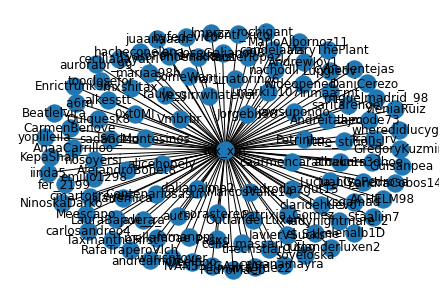

In [33]:
# Graph of me followers
mutuals_g = nx.Graph()
# For every mutual in me mutuals, add node and edge
mutuals_list = json.loads(
    df.loc[df['screen_name'] == me, 'mutuals'].values[0])
mutuals_g.add_node(me)
for k, v in mutuals_list.items():
    mutuals_g.add_node(v)
    mutuals_g.add_edge(me, v)

nx.draw(mutuals_g, with_labels=True)